# Heat equation 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

## Libraries

In [39]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [40]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [41]:
def Kphiphi_assembly(Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary
  
  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param)
  val2 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 0)
  val3 = K_ddot(kernel, Xomega, Xomega, k_param, 1, 1)
  #val3 = val2
  val4 = K_ddddot(kernel, Xomega, Xomega, k_param, 0, 0, 1, 1)
  val = val1 - h*val2 - h*(val3 - h*val4)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = K(kernel, Xomega, Xboundary, k_param)
  val2 = K_ddot(kernel, Xomega, Xboundary, k_param, 0, 0)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [42]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val2 = K_ddot(kernel, Xomega, Xtest, k_param, 0, 0)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [43]:
# X_full
Xfull = np.linspace(0,1,52)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = heat_u0(Xomega)
# Time step
h = 0.01

Build `Kphiphi`

In [44]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = 0.5)

Build `y_prev`

In [45]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [46]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + 1e-10*R,y_prev)

Get `K(Xtest,Xfull)`

In [47]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

In [48]:
u_next = np.dot(Kphi.T,sol)

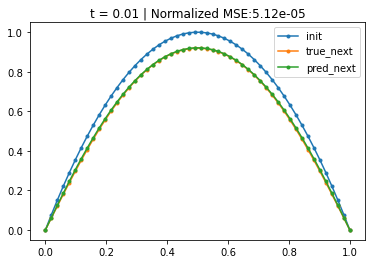

In [49]:
# Initial condition
plt.plot(Xfull,heat_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,heat_sol(Xfull,h,5),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,heat_sol(Xfull,h,5))/mean_squared_error(0*heat_sol(Xfull,h,5),heat_sol(Xfull,h,5))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

In [50]:
t = 0.2
steps = int(t//h)
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

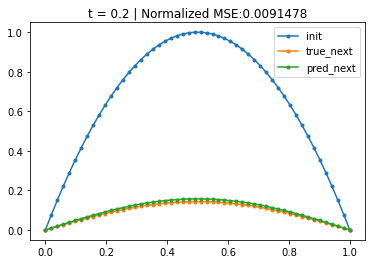

In [51]:
# Initial condition
plt.plot(Xfull,heat_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,heat_sol(Xfull,t,5),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,heat_sol(Xfull,t,5))/mean_squared_error(0*heat_sol(Xfull,t,5),heat_sol(Xfull,t,5))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

## Convergence

In [52]:
mses = []
sup_norms = []
l2_norms = []
L2_norms = []
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 0.01

    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

    R = jnp.diag(jnp.diag(Kphiphi))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = k_param)
    u_next = np.dot(Kphi.T,sol)
    # Vector of differences
    u_true = heat_sol(Xfull,h,5)   
    f = np.abs(u_next - u_true)**2
    # sup norm
    #sup_norms.append(f/np.max(ad_sol(Xfull,h,beta,5)))
    # l2 norm
    #l2_norms.append(norm(u_next - ad_sol(Xfull,h,beta,5),ord=2)/norm(ad_sol(Xfull,h,beta,5),ord=2))
    L2_norms.append(trap(f,delta))
    print(trap(f,delta))
    #nmse = mean_squared_error(u_next,ad_sol(Xfull,h,beta,5))/mean_squared_error(0*ad_sol(Xfull,h,beta,5),ad_sol(Xfull,h,beta,5))
    #mses.append(nmse)

1.9280050481414176e-05
2.5346149332618863e-05
2.2376720337029738e-05
2.105716646044015e-05
2.0439073975890113e-05
2.005168404098428e-05
1.966898691782479e-05
1.9113820000685874e-05


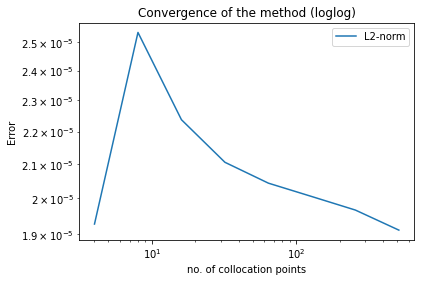

In [53]:
xrange = 2**np.arange(2,10)
#plt.loglog(xrange,sup_norms, label = 'sup-norm')
plt.loglog(xrange,L2_norms,label = 'L2-norm')
#plt.loglog(xrange,mses,label = 'mse')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

In [54]:
mses = []
sup_norms = []
l2_norms = []
L2_norms = []
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 0.01/2

    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

    R = jnp.diag(jnp.diag(Kphiphi))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = k_param)
    u_next = np.dot(Kphi.T,sol)
    # Vector of differences
    u_true = heat_sol(Xfull,h,5)   
    f = np.abs(u_next - u_true)**2
    # sup norm
    #sup_norms.append(f/np.max(ad_sol(Xfull,h,beta,5)))
    # l2 norm
    #l2_norms.append(norm(u_next - ad_sol(Xfull,h,beta,5),ord=2)/norm(ad_sol(Xfull,h,beta,5),ord=2))
    L2_norms.append(trap(f,delta))
    print(trap(f,delta))
    #nmse = mean_squared_error(u_next,ad_sol(Xfull,h,beta,5))/mean_squared_error(0*ad_sol(Xfull,h,beta,5),ad_sol(Xfull,h,beta,5))
    #mses.append(nmse)

1.2260049490109147e-06
1.1407458306668725e-05
9.423934542822917e-06
7.755447183845192e-06
6.867868267487514e-06
6.4863564994897215e-06
6.346423688241609e-06
6.265041163461233e-06


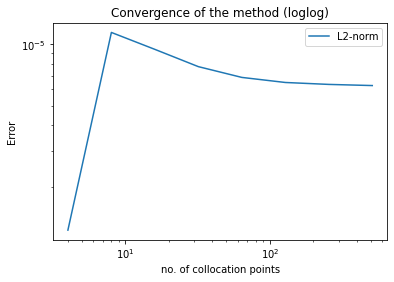

In [55]:
xrange = 2**np.arange(2,10)
#plt.loglog(xrange,sup_norms, label = 'sup-norm')
plt.loglog(xrange,L2_norms,label = 'L2-norm')
#plt.loglog(xrange,mses,label = 'mse')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- Time error dominant ! 

In [56]:
mses = []
sup_norms = []
l2_norms = []
L2_norms = []
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 0.01/10

    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

    R = jnp.diag(jnp.diag(Kphiphi))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = k_param)
    u_next = np.dot(Kphi.T,sol)
    # Vector of differences
    u_true = heat_sol(Xfull,h,5)   
    f = np.abs(u_next - u_true)**2
    # sup norm
    #sup_norms.append(f/np.max(ad_sol(Xfull,h,beta,5)))
    # l2 norm
    #l2_norms.append(norm(u_next - ad_sol(Xfull,h,beta,5),ord=2)/norm(ad_sol(Xfull,h,beta,5),ord=2))
    L2_norms.append(trap(f,delta))
    print(trap(f,delta))
    #nmse = mean_squared_error(u_next,ad_sol(Xfull,h,beta,5))/mean_squared_error(0*ad_sol(Xfull,h,beta,5),ad_sol(Xfull,h,beta,5))
    #mses.append(nmse)

2.1119526864213675e-06
2.1147516350974144e-05
2.3604698615342506e-05
2.2747926949381938e-05
2.2098952925131867e-05
2.1876027599601412e-05
2.1910944447228003e-05
2.2006255063230352e-05


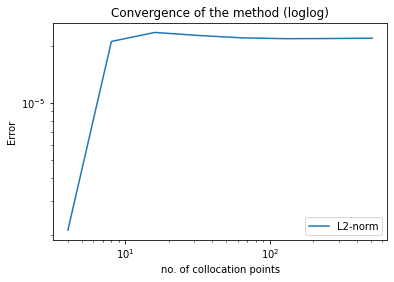

In [57]:
xrange = 2**np.arange(2,10)
#plt.loglog(xrange,sup_norms, label = 'sup-norm')
plt.loglog(xrange,L2_norms,label = 'L2-norm')
#plt.loglog(xrange,mses,label = 'mse')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- Poisson example and get the convergence plot ! 